<a href="https://colab.research.google.com/github/adir-hil/HeteroGraphs-for-OC-logs/blob/main/production_preprocess_R1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Import & initial dataype conversion**
------------------------------------------

In [ ]:
from IPython.display import clear_output
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
clear_output()

In [ ]:
import pandas as pd
from google.colab import drive,runtime
import numpy as np
import torch
import importlib
from torch_geometric.data import HeteroData
import networkx as nx
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import OneHotEncoder

In [ ]:
drive.mount('/content/gdrive',force_remount=True)
%cd gdrive/MyDrive/ocel

Mounted at /content/gdrive
/content/gdrive/MyDrive/ocel


In [ ]:
# importlib.reload(utility_funcs)
import utility_funcs

In [ ]:
new_df_lc = pd.read_csv('/content/gdrive/MyDrive/ocel/with_lables.csv')
new_df_lc['LIFECYCLE_BATCH'] = new_df_lc['LIFECYCLE_BATCH'].astype(str)
new_df_lc['TIMESTAMP'] = pd.to_datetime(new_df_lc['TIMESTAMP'])
new_df_lc.drop("Unnamed: 0",axis=1,inplace =True)
new_df_lc.drop("Unnamed: 0.1",axis=1,inplace =True)

<ipython-input-5-5ec6109a9d4b>:1: DtypeWarning: Columns (3,9,23) have mixed types. Specify dtype option on import or set low_memory=False.
  new_df_lc = pd.read_csv('/content/gdrive/MyDrive/ocel/with_lables.csv')


## **Nodes & edges matrices creation**
------------------------------------

### **Feature matrices for nodes** <br> (will be stored in a dictionary for later use)

1.Identity matrices for nodes without features





In [ ]:
cols = ['PRODUCT', 'MATERIAL', 'LIFECYCLE_BATCH','LOT','LOCATION',
        'AREA','SITE','PMX_USER','PMX_ORDER','ORDER_STEP']
nodes_types = ['product', 'material', 'batch','lot','location',
               'area','site','employee','order','order_step']

col_mapping = {node_type: col for node_type, col in zip(nodes_types, cols)}
node_features_dict = utility_funcs.create_identity_matrices_for_nodes(new_df_lc, col_mapping)


Processing column: PRODUCT (mapped to key: product)
Feature matrix shape for product: (434, 434)
Processing column: MATERIAL (mapped to key: material)
Feature matrix shape for material: (707, 707)
Processing column: LIFECYCLE_BATCH (mapped to key: batch)
Feature matrix shape for batch: (1165, 1165)
Processing column: LOT (mapped to key: lot)
Feature matrix shape for lot: (2524, 2524)
Processing column: LOCATION (mapped to key: location)
Feature matrix shape for location: (6073, 6073)
Processing column: AREA (mapped to key: area)
Feature matrix shape for area: (26, 26)
Processing column: SITE (mapped to key: site)
Feature matrix shape for site: (2, 2)
Processing column: PMX_USER (mapped to key: employee)
Feature matrix shape for employee: (308, 308)
Processing column: PMX_ORDER (mapped to key: order)
Feature matrix shape for order: (4768, 4768)
Processing column: ORDER_STEP (mapped to key: order_step)
Feature matrix shape for order_step: (7326, 7326)


2.Events (the only node with features)

In [ ]:
# Create the feature matrix
event_features = utility_funcs.create_event_feature_matrix(new_df_lc)
# Check the shape of the resulting matrix
print("Feature matrix shape:", event_features.shape)
# add to matrices dict
node_features_dict['event'] = event_features

(271032, 9)
(271032, 24)
(271032, 3)
(271032, 2)
(271032, 38)
Feature matrix shape: (271032, 38)


3.TU Matrix (will be stored as a torch sparse tensor)

In [ ]:
# Create the sparse tensor
tu_sparse_identity = utility_funcs.create_sparse_identity_tensor(new_df_lc, 'TU')
# add to matrices dict
node_features_dict['tu'] = tu_sparse_identity

4.LOCATION Matrix (will be stored with area and site as one-hot encoded features)

In [ ]:
# @title
df_loc = new_df_lc[['LOCATION','AREA','SITE']].dropna().drop_duplicates()
df_lc_encoded = pd.get_dummies(df_loc, columns=['AREA','SITE'], prefix=['AREA','SITE'])
unique_locations_list = new_df_lc['LOCATION'].dropna().unique()
location_mapping = { loc_str: i for i, loc_str in enumerate(unique_locations_list) }
# 1) Re-index the DataFrame by `LOCATION`
df_lc_encoded = df_lc_encoded.set_index('LOCATION')
# Extract just the one-hot columns (since index is now location).
location_features = df_lc_encoded.values  # shape: [num_locations x (26 + 2)]
# Convert to a Torch tensor (float)
# location_features_tensor = torch.from_numpy(location_features).float()
# hetero_data['location'].x = location_features_tensor
node_features_dict['location'] = location_features

### **Creating all possible edge adjacency matrices** <br> (will be stored in a dictionary for later use)

1. O2O + E2O edges

In [ ]:
# Edges for R1

cols = [
    'PRODUCT',
    'MATERIAL',
    'LIFECYCLE_BATCH',
    'LOT',
    'AREA',
    'SITE',
    'LOCATION',
    'PMX_USER',
    'PMX_ORDER',
    'ORDER_STEP',
    'TU'
]
# All possible edges
#--------------------------------------------------------------------
# 1) O2O: Generate all possible directed pairs from the cols list
all_possible_o2o = {(c1, c2) for c1 in cols for c2 in cols if c1 != c2}
all_O2O_edge_types = sorted(all_possible_o2o)

# 2) E2O: We want edges of the form ('EVENT_ID', <column_from_cols>)
all_possible_e2o = {('NEW_EVENT_ID', c) for c in cols}
all_E2O_edge_types = sorted(all_possible_e2o)


edge_types_list = all_O2O_edge_types + all_E2O_edge_types
edge_adj_matrix_dict = utility_funcs.create_edge_adjacency_matrices(new_df_lc, edge_types_list)

Processing edge type: AREA -> LIFECYCLE_BATCH
Created adjacency matrix for ('AREA', 'LIFECYCLE_BATCH') with shape (2, 9753).
Processing edge type: AREA -> LOCATION
Created adjacency matrix for ('AREA', 'LOCATION') with shape (2, 6073).
Processing edge type: AREA -> LOT
Created adjacency matrix for ('AREA', 'LOT') with shape (2, 2639).
Processing edge type: AREA -> MATERIAL
Created adjacency matrix for ('AREA', 'MATERIAL') with shape (2, 754).
Processing edge type: AREA -> ORDER_STEP
Created adjacency matrix for ('AREA', 'ORDER_STEP') with shape (2, 8075).
Processing edge type: AREA -> PMX_ORDER
Created adjacency matrix for ('AREA', 'PMX_ORDER') with shape (2, 6894).
Processing edge type: AREA -> PMX_USER
Created adjacency matrix for ('AREA', 'PMX_USER') with shape (2, 688).
Processing edge type: AREA -> PRODUCT
Created adjacency matrix for ('AREA', 'PRODUCT') with shape (2, 1742).
Processing edge type: AREA -> SITE
Created adjacency matrix for ('AREA', 'SITE') with shape (2, 26).
Proce

2. E2E edges

In [ ]:
e2e_edge_matrix, e2e_edge_labels, missing_nodes = \
utility_funcs.create_e2e_edge_matrix(
    df=new_df_lc,
    batch_col="LIFECYCLE_BATCH",
    event_col="NEW_EVENT_ID",
    label_col="log_days_to_finish"
)

Unique nodes in edges: 271032
Unique NEW_EVENT_ID in DataFrame: 271032
Number of missing nodes: 0
Edge matrix shape: (2, 269867)


###**Edges to be included in R1**

In [ ]:
# @title
edge_types_R1 = [
#-------------Hierarchical object relationships-------------------------
   {
        'edge_type': ('area', 'O2O', 'site'),
        'col_src': 'AREA',
        'col_dst': 'SITE',
        'edge_class': 'O2O'
    },
   {
        'edge_type': ('location', 'O2O', 'area'),
        'col_src': 'LOCATION',
        'col_dst': 'AREA',
        'edge_class': 'O2O'
    },
    {
        'edge_type': ('tu', 'O2O', 'product'),
        'col_src': 'TU',
        'col_dst': 'PRODUCT',
        'edge_class': 'O2O'
    },
    {
        'edge_type': ('tu', 'O2O', 'material'),
        'col_src': 'TU',
        'col_dst': 'MATERIAL',
        'edge_class': 'O2O'
    },
    {
        'edge_type': ('tu', 'O2O', 'lot'),
        'col_src': 'TU',
        'col_dst': 'LOT',
        'edge_class': 'O2O'
    },
    {
        'edge_type': ('order', 'O2O', 'order_step'),
        'col_src': 'PMX_ORDER',
        'col_dst': 'ORDER_STEP',
        'edge_class': 'O2O'
    },
    {
        'edge_type': ('order', 'O2O', 'batch'),
        'col_src': 'PMX_ORDER',
        'col_dst': 'LIFECYCLE_BATCH',
        'edge_class': 'O2O'
    },
#-------------Direct object relationships-------------------------
    {
        'edge_type': ('tu', 'O2O', 'employee'),
        'col_src': 'TU',
        'col_dst': 'PMX_USER',
        'edge_class': 'O2O'
    },
    {
        'edge_type': ('tu', 'O2O', 'location'),
        'col_src': 'TU',
        'col_dst': 'LOCATION',
        'edge_class': 'O2O'
    },
    {
        'edge_type': ('tu', 'O2O', 'order_step'),
        'col_src': 'TU',
        'col_dst': 'ORDER_STEP',
        'edge_class': 'O2O'
    },
    {
        'edge_type': ('order_step', 'O2O', 'employee'),
        'col_src': 'ORDER_STEP',
        'col_dst': 'PMX_USER',
        'edge_class': 'O2O'
    },
    {
        'edge_type': ('order_step', 'O2O', 'location'),
        'col_src': 'ORDER_STEP',
        'col_dst': 'LOCATION',
        'edge_class': 'O2O'
    },
    {
        'edge_type': ('location', 'O2O', 'employee'),
        'col_src': 'LOCATION',
        'col_dst': 'PMX_USER',
        'edge_class': 'O2O'
    },
#-------------Event to Object Relationships---------------------
    {
        'edge_type': ('event', 'E2O', 'location'),
        'col_src': 'NEW_EVENT_ID',
        'col_dst': 'LOCATION',
        'edge_class': 'E2O'
    },
    {
        'edge_type': ('event', 'E2O', 'order_step'),
        'col_src': 'NEW_EVENT_ID',
        'col_dst': 'ORDER_STEP',
        'edge_class': 'E2O'
    },
    {
        'edge_type': ('event', 'E2O', 'employee'),
        'col_src': 'NEW_EVENT_ID',
        'col_dst': 'PMX_USER',
        'edge_class': 'E2O'
    },
    {
        'edge_type': ('event', 'E2O', 'tu'),
        'col_src': 'NEW_EVENT_ID',
        'col_dst': 'TU',
        'edge_class': 'E2O'
    },
    {
        'edge_type': ('event', 'E2O', 'batch'),
        'col_src': 'NEW_EVENT_ID',
        'col_dst': 'LIFECYCLE_BATCH',
        'edge_class': 'E2O'
    },
#-----------Event to Event Relationships------------------
    {
        'edge_type': ('event', 'E2E', 'event'),
        'col_src': 'NEW_EVENT_ID',
        'col_dst': 'NEW_EVENT_ID',
        'edge_class': 'E2E'
    },
]

In [ ]:
# @title
edge_types = [
    {
        'edge_type': ('tu', 'O2O', 'product'),
        'col_src': 'TU',
        'col_dst': 'PRODUCT',
        'edge_class': 'O2O'
    },
    {
        'edge_type': ('tu', 'O2O', 'material'),
        'col_src': 'TU',
        'col_dst': 'MATERIAL',
        'edge_class': 'O2O'
    },
    {
        'edge_type': ('tu', 'O2O', 'order_step'),
        'col_src': 'TU',
        'col_dst': 'ORDER_STEP',
        'edge_class': 'O2O'
    },
    {
        'edge_type': ('tu', 'O2O', 'location'),
        'col_src': 'TU',
        'col_dst': 'LOCATION',
        'edge_class': 'O2O'
    },
    {
        'edge_type': ('tu', 'O2O', 'lot'),
        'col_src': 'TU',
        'col_dst': 'LOT',
        'edge_class': 'O2O'
    },
    {
        'edge_type': ('tu', 'O2O', 'batch'),
        'col_src': 'TU',
        'col_dst': 'LIFECYCLE_BATCH',
        'edge_class': 'O2O'
    },
    {
        'edge_type': ('order', 'O2O', 'batch'),
        'col_src': 'PMX_ORDER',
        'col_dst': 'LIFECYCLE_BATCH',
        'edge_class': 'O2O'
    },
    {
        'edge_type': ('order', 'O2O', 'order_step'),
        'col_src': 'PMX_ORDER',
        'col_dst': 'ORDER_STEP',
        'edge_class': 'O2O'
    },
    {
        'edge_type': ('order_step', 'O2O', 'employee'),
        'col_src': 'ORDER_STEP',
        'col_dst': 'PMX_USER',
        'edge_class': 'O2O'
    },
    {
        'edge_type': ('area', 'O2O', 'location'),
        'col_src': 'AREA',
        'col_dst': 'LOCATION',
        'edge_class': 'O2O'
    },
    {
        'edge_type': ('area', 'O2O', 'site'),
        'col_src': 'AREA',
        'col_dst': 'SITE',
        'edge_class': 'O2O'
    },
    {
        'edge_type': ('event', 'E2O', 'location'),
        'col_src': 'NEW_EVENT_ID',
        'col_dst': 'LOCATION',
        'edge_class': 'E2O'
    },
    {
        'edge_type': ('event', 'E2O', 'order_step'),
        'col_src': 'NEW_EVENT_ID',
        'col_dst': 'ORDER_STEP',
        'edge_class': 'E2O'
    },
    {
        'edge_type': ('event', 'E2O', 'employee'),
        'col_src': 'NEW_EVENT_ID',
        'col_dst': 'PMX_USER',
        'edge_class': 'E2O'
    },
    {
        'edge_type': ('event', 'E2O', 'tu'),
        'col_src': 'NEW_EVENT_ID',
        'col_dst': 'TU',
        'edge_class': 'E2O'
    },
    {
        'edge_type': ('event', 'E2O', 'batch'),
        'col_src': 'NEW_EVENT_ID',
        'col_dst': 'LIFECYCLE_BATCH',
        'edge_class': 'E2O'
    },
    {
        'edge_type': ('event', 'E2E', 'event'),
        'col_src': 'NEW_EVENT_ID',
        'col_dst': 'NEW_EVENT_ID',
        'edge_class': 'E2E'
    },
]

## **Heterodata object creation for R1**
------------------------------------
### **Creating nodes + node to index mapping**

In [ ]:
data = HeteroData()
data = utility_funcs.populate_hetero_data(data,node_features_dict)

In [ ]:
node_to_index_dict = utility_funcs.create_node_index_mappings(new_df_lc, cols + ['NEW_EVENT_ID'])

### **Creating edges + split + masks**

In [ ]:
def process_edge_type(
    data,
    edge_type,
    edge_class,
    df,
    col_src,
    col_dst,
    col_batch,
    col_labels,
    src_dict,
    dst_dict,
    train_batches,
    val_batches,
    test_batches
):
    """
    Processes a single edge type based on its class and adds edges and masks to the HeteroData object.
    """

    if edge_class == 'E2E':
        # E2E logic
        edges = []
        labels = []
        train_mask = []
        val_mask = []
        test_mask = []

        # For each unique batch, create edges between consecutive events
        for batch, group in df.drop_duplicates(subset=[col_batch, col_src]).groupby(col_batch):
            events = group[col_src].values
            log_days_to_finish = group[col_labels].values  # edge labels from col_labels

            source = events[:-1]
            target = events[1:]
            edge_labels = log_days_to_finish[:-1]

            batch_edges = np.vstack((source, target))
            edges.append(batch_edges)
            labels.append(edge_labels)

            # Assign masks based on which split the batch belongs to
            if batch in train_batches:
                train_mask.extend([True] * len(source))
                val_mask.extend([False] * len(source))
                test_mask.extend([False] * len(source))
            elif batch in val_batches:
                train_mask.extend([False] * len(source))
                val_mask.extend([True] * len(source))
                test_mask.extend([False] * len(source))
            else:  # test batches
                train_mask.extend([False] * len(source))
                val_mask.extend([False] * len(source))
                test_mask.extend([True] * len(source))

        if edges:
            edge_matrix = np.hstack(edges)         # shape = (2, total_num_edges)
            edge_labels = np.hstack(labels)         # shape = (total_num_edges,)
        else:
            edge_matrix = np.empty((2, 0), dtype=np.int64)
            edge_labels = np.empty(0, dtype=np.float64)
            train_mask = []
            val_mask = []
            test_mask = []

        # Convert to torch tensors
        data[edge_type].edge_index = torch.tensor(edge_matrix, dtype=torch.long)
        data[edge_type].edge_labels = torch.tensor(edge_labels, dtype=torch.float)
        data[edge_type].train_mask = torch.tensor(train_mask, dtype=torch.bool)
        data[edge_type].val_mask = torch.tensor(val_mask, dtype=torch.bool)
        data[edge_type].test_mask = torch.tensor(test_mask, dtype=torch.bool)

    else:
        # O2O or E2O
        # We'll also add the reverse edges automatically
        reverse_edge_type = (edge_type[2], edge_type[1], edge_type[0])

        # Drop duplicates and rename the batch column for convenience
        filtered_df = df[[col_src, col_dst, col_batch]].dropna().drop_duplicates()
        filtered_df.columns.values[2] = "BATCH"
        col_batch = "BATCH"

        if edge_class == 'O2O':
            # Build a reverse mapping: {node_value -> index} for both src & dst
            # (We assume src_dict, dst_dict map {index -> node_value}, so we invert them.)
            src_reverse_dict = {v: k for k, v in src_dict.items()}
            dst_reverse_dict = {v: k for k, v in dst_dict.items()}

            # Map actual data to the indices
            filtered_df['SRC_IDX'] = filtered_df[col_src].map(src_reverse_dict)
            filtered_df['DST_IDX'] = filtered_df[col_dst].map(dst_reverse_dict)

            # Check for missing mappings
            if filtered_df[['SRC_IDX', 'DST_IDX']].isna().any().any():
                print(f"Warning: Some nodes not found in the dictionaries for edge type {edge_type}!")

        elif edge_class == 'E2O':
            # For E2O, the source is used directly, and only the destination is mapped
            dst_reverse_dict = {v: k for k, v in dst_dict.items()}
            filtered_df['SRC_IDX'] = filtered_df[col_src]
            filtered_df['DST_IDX'] = filtered_df[col_dst].map(dst_reverse_dict)

            if filtered_df['DST_IDX'].isna().any():
                print(f"Warning: Some destination nodes not found in dictionary for edge type {edge_type}!")

        # Build the edge matrix: shape = (2, num_edges)
        edge_matrix = np.array([filtered_df['SRC_IDX'].values, filtered_df['DST_IDX'].values])

        # Assign split membership: train / val / test
        filtered_df['set_type'] = np.select(
            [
                filtered_df[col_batch].isin(train_batches),
                filtered_df[col_batch].isin(val_batches),
                filtered_df[col_batch].isin(test_batches)
            ],
            ['train', 'val', 'test'],
            default=None
        )

        train_mask = torch.tensor((filtered_df['set_type'] == 'train').values, dtype=torch.bool)
        val_mask   = torch.tensor((filtered_df['set_type'] == 'val').values,   dtype=torch.bool)
        test_mask  = torch.tensor((filtered_df['set_type'] == 'test').values,  dtype=torch.bool)

        # Store in HeteroData for the forward edge
        if edge_class == 'O2O':
          data[edge_type].edge_index = torch.tensor(edge_matrix, dtype=torch.long)
          data[edge_type].train_mask = train_mask
          data[edge_type].val_mask   = val_mask
          data[edge_type].test_mask  = test_mask

        # Build reversed edge matrix for the backward edge
        reversed_edge_matrix = edge_matrix[[1, 0], :]
        data[reverse_edge_type].edge_index = torch.tensor(reversed_edge_matrix, dtype=torch.long)
        data[reverse_edge_type].train_mask = train_mask
        data[reverse_edge_type].val_mask   = val_mask
        data[reverse_edge_type].test_mask  = test_mask


def create_hetero_masks_and_edges(
    df: pd.DataFrame,
    data: HeteroData,
    edge_types: list,
    node_to_index_dict: dict,
    ratio_dict: dict,
    col_batch: str = 'LIFECYCLE_BATCH',
    col_labels: str = 'log_days_to_finish'
) -> HeteroData:
    """
    1) Splits the values in 'col_batch' into train, val, test sets based on ratio_dict.
    2) Iterates over edge_types, calling process_edge_type for each one.
    3) Returns the updated HeteroData object with edge_index and train/val/test masks.

    Args:
        df (pd.DataFrame): The DataFrame containing your graph-related columns.
        data (HeteroData): The PyG HeteroData object to populate with edges.
        edge_types (list): A list of dicts describing each edge's metadata. Example element:
            {
                'edge_type': ('tu', 'O2O', 'product'),  # (src_node_type, qualifier, dst_node_type)
                'col_src': 'TU',
                'col_dst': 'PRODUCT',
                'edge_class': 'O2O'    # or 'E2O' or 'E2E'
            }
        node_to_index_dict (dict): Maps column names -> {index -> node_value} dicts
                                   (produced by create_node_index_mappings).
        ratio_dict (dict): Specifies the train/val/test ratio. e.g. {"train": 0.7, "val": 0.1, "test": 0.2}.
        col_batch (str): The column used for splitting into train/val/test sets. Defaults to 'LIFECYCLE_BATCH'.
        col_labels (str): The column used for E2E edge labels. Defaults to 'log_days_to_finish'.

    Returns:
        HeteroData: The updated HeteroData with edges and masks added.
    """

    # ---------------------
    # Step 1: Split Batches
    # ---------------------
    unique_batches = df[col_batch].dropna().unique()
    total_batches = len(unique_batches)

    # Sort or shuffle if needed:
    # np.random.shuffle(unique_batches)  # only if you want a random split, for example

    train_end = int(total_batches * ratio_dict["train"])
    val_end   = train_end + int(total_batches * ratio_dict["val"])
    # test_end = val_end + int(total_batches * ratio_dict["test"])  # would be total_batches in most cases

    train_batches = set(unique_batches[:train_end])
    val_batches   = set(unique_batches[train_end:val_end])
    test_batches  = set(unique_batches[val_end:])

    print(f"Total Batches: {total_batches}")
    print(f"Train Batches:      {len(train_batches)}")
    print(f"Validation Batches: {len(val_batches)}")
    print(f"Test Batches:       {len(test_batches)}")

    # --------------------------------------------------------
    # Step 2: For Each Edge Type, Process and Add to HeteroData
    # --------------------------------------------------------
    for edge in edge_types:
        edge_type = edge['edge_type']    # (node_src, edge_qualifier, node_dst)
        col_src   = edge['col_src']
        col_dst   = edge['col_dst']
        edge_class = edge['edge_class']

        src_dict = node_to_index_dict.get(col_src, {})
        dst_dict = node_to_index_dict.get(col_dst, {})

        # Print or log to see what edges you're creating
        print(f"Creating edges for {edge_type} from columns {col_src} -> {col_dst} [class={edge_class}]")

        process_edge_type(
            data=data,
            edge_type=edge_type,
            edge_class=edge_class,
            df=df,
            col_src=col_src,
            col_dst=col_dst,
            col_batch=col_batch,
            col_labels=col_labels,
            src_dict=src_dict,
            dst_dict=dst_dict,
            train_batches=train_batches,
            val_batches=val_batches,
            test_batches=test_batches
        )

    # Optional final validation
    data.validate(raise_on_error=True)
    return data


In [ ]:
ratio_dict = {"train": 0.7, "val": 0.1, "test": 0.2}
data = create_hetero_masks_and_edges(
    df=new_df_lc,
    data=data,
    edge_types=edge_types_R1,
    node_to_index_dict=node_to_index_dict,  # from create_node_index_mappings
    ratio_dict=ratio_dict,
    col_batch='LIFECYCLE_BATCH',
    col_labels='log_days_to_finish'
)

Total Batches: 1165
Train Batches:      815
Validation Batches: 116
Test Batches:       234
Creating edges for ('area', 'O2O', 'site') from columns AREA -> SITE [class=O2O]
Creating edges for ('location', 'O2O', 'area') from columns LOCATION -> AREA [class=O2O]
Creating edges for ('tu', 'O2O', 'product') from columns TU -> PRODUCT [class=O2O]
Creating edges for ('tu', 'O2O', 'material') from columns TU -> MATERIAL [class=O2O]
Creating edges for ('tu', 'O2O', 'lot') from columns TU -> LOT [class=O2O]
Creating edges for ('order', 'O2O', 'order_step') from columns PMX_ORDER -> ORDER_STEP [class=O2O]
Creating edges for ('order', 'O2O', 'batch') from columns PMX_ORDER -> LIFECYCLE_BATCH [class=O2O]
Creating edges for ('tu', 'O2O', 'employee') from columns TU -> PMX_USER [class=O2O]
Creating edges for ('tu', 'O2O', 'location') from columns TU -> LOCATION [class=O2O]
Creating edges for ('tu', 'O2O', 'order_step') from columns TU -> ORDER_STEP [class=O2O]
Creating edges for ('order_step', 'O2O

### **Visualizing meta-graph**

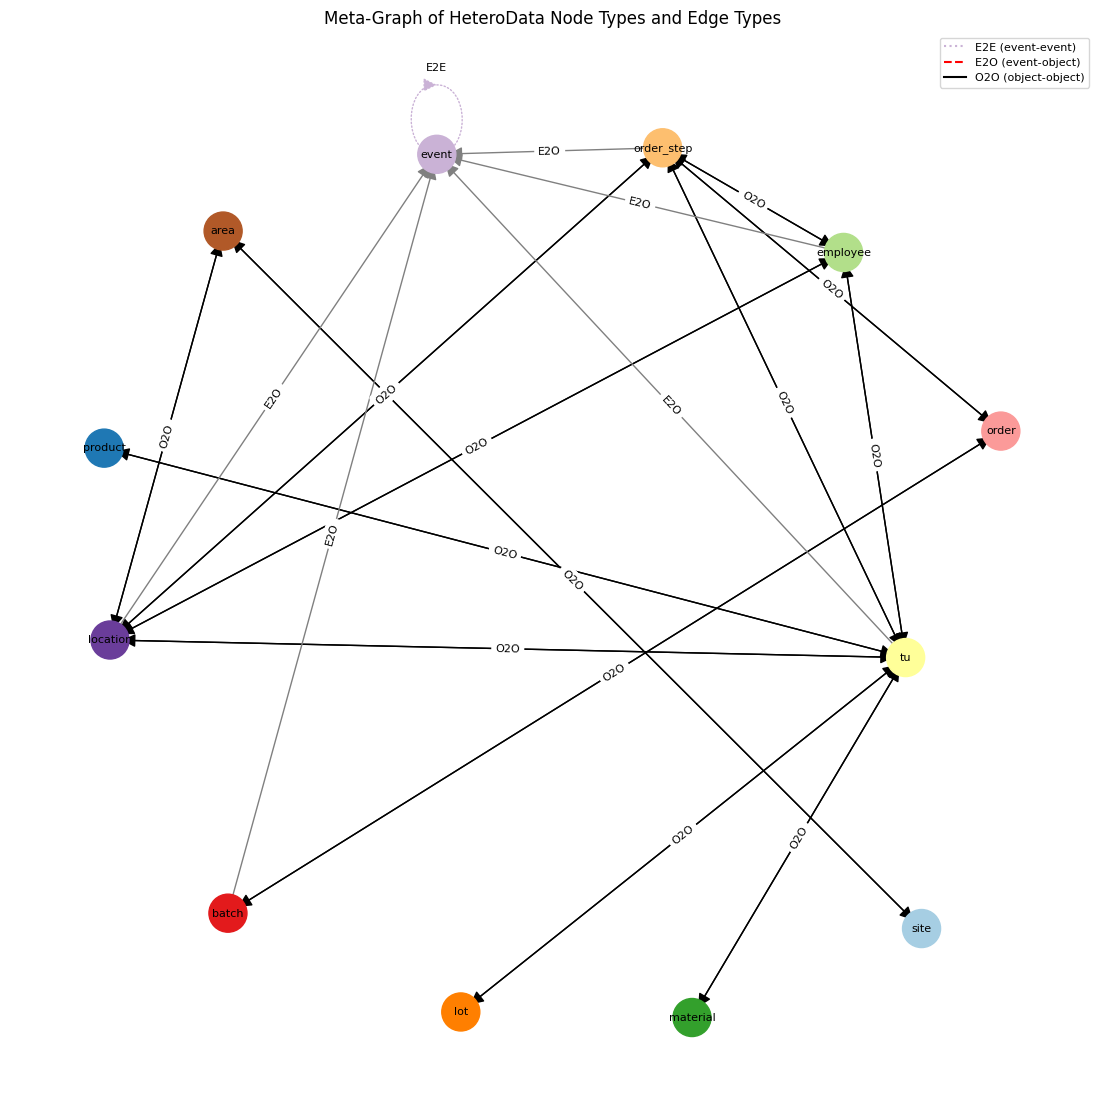

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
import random

def visualize_heterodata_meta_graph(data, figsize=(14, 14), seed=9, k=3.5, custom_colors=None):
    """
    Visualizes a meta-level graph of node types and edge types from a PyG HeteroData object.
    Each node in the NetworkX plot is a node type, and each directed edge is an edge type.
    The visualization now uses colors, line styles, and a legend similar to visualize_heterodata_graph.

    Args:
        data (HeteroData): A PyG HeteroData object. We assume data.node_types and data.edge_types
                           are available (PyG >= 2.0).
        figsize (tuple): Figure size for the matplotlib plot.
        seed (int): Random seed passed to NetworkX's spring_layout for reproducibility.
        k (float): The optimal distance between nodes in the layout. Smaller means tighter clusters.
        custom_colors (dict, optional): A dictionary mapping node types to colors.
                                        e.g. {"event": "red", "order": "green"}.
                                        If not provided, a default color cycle is used.

    Returns:
        str: The file path where the plot image is saved.
    """
    import networkx as nx
    import matplotlib.pyplot as plt
    import matplotlib.lines as mlines
    import random

    # 1) Gather all node types and edge types from the HeteroData object
    node_types = list(data.node_types)  # e.g. ['event', 'employee', 'order', ...]
    edge_types = list(data.edge_types)  # e.g. [('event','E2O','order_step'), ...]

    # 2) Initialize a directed graph at the meta-level
    G = nx.DiGraph()

    # 3) Add each node type as a single node in the graph
    for ntype in node_types:
        G.add_node(ntype)

    # 4) Add an edge for each (src_type, relation, dst_type)
    #    We store the "relation" in the edge attribute for labeling.
    for (src_type, relation, dst_type) in edge_types:
        G.add_edge(src_type, dst_type, relation=relation)

    # 5) Define or generate a color for each node type (using same logic as visualize_heterodata_graph)
    if custom_colors is not None:
        node_color_map = {}
        for ntype in node_types:
            if ntype in custom_colors:
                node_color_map[ntype] = custom_colors[ntype]
            else:
                node_color_map[ntype] = "#%06x" % random.randint(0, 0xFFFFFF)
    else:
        default_cycle = [
            "#1f78b4", "#33a02c", "#e31a1c", "#ff7f00", "#6a3d9a",
            "#b15928", "#a6cee3", "#b2df8a", "#fb9a99", "#fdbf6f",
            "#cab2d6", "#ffff99"
        ]
        node_color_map = {ntype: default_cycle[i % len(default_cycle)]
                          for i, ntype in enumerate(node_types)}

    # Build a color list for the nodes in the meta graph
    node_colors = [node_color_map[ntype] for ntype in G.nodes()]

    # 6) Compute layout positions for the meta-nodes
    pos = nx.spring_layout(G, seed=seed, k=k)

    # 7) Draw the figure with updated style
    plt.figure(figsize=figsize)

    # Draw nodes (using a similar node size to visualize_heterodata_graph)
    nx.draw_networkx_nodes(G, pos, node_size=750, node_color=node_colors)

    # Define edge line styles and colors (similar to visualize_heterodata_graph)
    edge_line_styles = {
        'E2E': 'dotted',
        'O2E': 'dashed',
        'O2O': 'solid'
    }

    # Group meta edges by relation type for custom drawing
    edge_groups = {}
    for u, v, d in G.edges(data=True):
        relation = d.get('relation', 'O2O')  # Default to O2O if missing
        edge_groups.setdefault(relation, []).append((u, v))

    # Draw each group with its own style and color
    for relation, edges in edge_groups.items():
        if relation == 'E2E':
            edge_color = node_color_map.get("event", "#ff00ff")
        elif relation == 'O2O':
            edge_color = "black"
        elif relation == 'O2E':
            edge_color = "red"
        else:
            edge_color = "gray"
        line_style = edge_line_styles.get(relation, "solid")
        nx.draw_networkx_edges(
            G, pos, edgelist=edges, arrowstyle='-|>', arrowsize=20,
            edge_color=edge_color, style=line_style,connectionstyle="arc3, rad=0.0"
        )

    # Draw node labels
    nx.draw_networkx_labels(G, pos, font_size=8, font_color='black')

    # Draw edge labels (the "relation" attribute)
    edge_labels = nx.get_edge_attributes(G, 'relation')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    # 8) Create legend handles (using same legend as visualize_heterodata_graph)
    e2e_handle = mlines.Line2D([], [], color=node_color_map.get("event", "#ff00ff"),
                               linestyle='dotted', label='E2E (event-event)')
    e2o_handle = mlines.Line2D([], [], color='red', linestyle='dashed',
                               label='E2O (event-object)')
    o2o_handle = mlines.Line2D([], [], color='black', linestyle='solid',
                               label='O2O (object-object)')
    plt.legend(handles=[e2e_handle, e2o_handle, o2o_handle], loc='best', fontsize=8)

    # Final formatting
    plt.title("Meta-Graph of HeteroData Node Types and Edge Types")
    plt.axis('off')
    plot_path = "meta-graph.png"
    plt.show()
visualize_heterodata_meta_graph(data)

In [ ]:
# data2=  torch.load('R1_with_masks_prod.pth')
data3 = torch.load('data_prod_R1_with_masks.pth')
del data3[('event, directly_follows, event')]
del data3['(event, directly_follows, event)']

<ipython-input-5-7d275141abf9>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data3 = torch.load('data_prod_R1_with_masks.pth')


In [ ]:
torch.save(data,'R1_only_tu_sparse.pth')
# data = torch.load('R1_with_masks_prod_e2b+t2b+e2l.pth')

## **Heterodata object creation for trace prefixes - R3+R4**
------------------------------------


In [ ]:
test_df = new_df_lc[new_df_lc['LIFECYCLE_BATCH'] == '2011157']
all_possible_activities = new_df_lc['ACTIVITY'].unique()
graphs = process_all_batches(test_df, edge_types_R1, 'R1')

In [ ]:
print(f' num of prefixes in batch 2011157: {len(graphs)}')
print(f' num of events in batch 2011157: {test_df["NEW_EVENT_ID"].nunique()}')

 num of prefixes in batch 2011157: 830
 num of events in batch 2011157: 326


In [ ]:
import pandas as pd
import numpy as np

# Compute the number of unique events per batch.
# Each batch is identified by 'LIFECYCLE_BATCH', and each unique 'NEW_EVENT_ID' denotes a unique event.
batch_event_counts = new_df_lc.groupby("LIFECYCLE_BATCH")["NEW_EVENT_ID"].nunique()

# For each batch, the number of prefixes is (n - 2) if n >= 3; otherwise, it's 0.
prefix_counts = batch_event_counts.apply(lambda n: n - 2 if n >= 3 else 0)

# Calculate statistics.
total_prefixes = prefix_counts.sum()
avg_prefixes = prefix_counts.mean()
std_prefixes = prefix_counts.std()
min_prefixes = prefix_counts.min()
max_prefixes = prefix_counts.max()
mode_prefixes = prefix_counts.mode()

print("Total number of prefixes:", total_prefixes)
print("Average number of prefixes per batch:", avg_prefixes)
print("Standard deviation of prefixes per batch:", std_prefixes)
print("Minimum number of prefixes in a batch:", min_prefixes)
print("Maximum number of prefixes in a batch:", max_prefixes)
if not mode_prefixes.empty:
    print("Mode of prefixes per batch:", mode_prefixes.iloc[0])
else:
    print("No mode found.")


Total number of prefixes: 268702
Average number of prefixes per batch: 230.64549356223176
Standard deviation of prefixes per batch: 139.09658993167162
Minimum number of prefixes in a batch: 43
Maximum number of prefixes in a batch: 1150
Mode of prefixes per batch: 186


In [ ]:
import numpy as np
import pandas as pd
import torch
from torch_geometric.data import HeteroData
from sklearn.preprocessing import OneHotEncoder
from typing import List, Dict, Any, Tuple, Iterator

def create_event_feature_matrix(df: pd.DataFrame, all_possible_activities: List[str]) -> np.ndarray:
    """
    Creates a node feature matrix for NEW_EVENT_ID where each row is a feature vector
    containing concatenated features:
      a. One-hot encoding of the 'ACTIVITY' column.
      b. Hour columns (hour_0 to hour_23).
      c. Tertile columns.
      d. grouped_time_since_first_day.
      e. DAYS_FROM_LC_START.

    Args:
        df (pd.DataFrame): Input dataframe (prefix) containing necessary columns.
        all_possible_activities (List[str]): List of all possible activities in the dataset.

    Returns:
        np.ndarray: A numpy array with shape (num_unique_events, total_feature_columns).
    """
    required_columns = (
        ['NEW_EVENT_ID', 'ACTIVITY', 'grouped_time_since_first_day', 'DAYS_FROM_LC_START'] +
        [f"hour_{i}" for i in range(24)] +
        ['tertile_12am-8am', 'tertile_8am-4pm', 'tertile_4pm-12am']
    )
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")

    # Group by NEW_EVENT_ID once to aggregate features per unique event.
    grouped = df.groupby('NEW_EVENT_ID', sort=False).first()

    # One-hot encode the 'ACTIVITY' column using all_possible_activities as categories.
    activity_encoder = OneHotEncoder(
        sparse_output=False,
        handle_unknown='ignore',
        categories=[all_possible_activities]
    )
    activity_encoded = activity_encoder.fit_transform(grouped[['ACTIVITY']])
    activity_df = pd.DataFrame(
        activity_encoded,
        columns=activity_encoder.get_feature_names_out(['ACTIVITY']),
        index=grouped.index
    )

    # Directly extract the remaining features from the grouped dataframe.
    hour_columns = [f"hour_{i}" for i in range(24)]
    hour_df = grouped[hour_columns]

    tertile_columns = ['tertile_12am-8am', 'tertile_8am-4pm', 'tertile_4pm-12am']
    tertile_df = grouped[tertile_columns]

    time_df = grouped[['grouped_time_since_first_day', 'DAYS_FROM_LC_START']]

    # Concatenate all features horizontally.
    full_features = pd.concat([activity_df, hour_df, tertile_df, time_df], axis=1)

    return full_features.to_numpy(dtype=np.float32)


def create_node_features(prefix: pd.DataFrame,
                         node_types_to_columns: Dict[str, str],
                         all_possible_activities: List[str]) -> Dict[str, np.ndarray]:
    """
    Create node features for each node type.

    For each node type specified in node_types_to_columns (excluding 'event'), an identity matrix is
    created where the size is determined by the number of unique values in that column. Additionally,
    for the 'event' node type, engineered features are computed via create_event_feature_matrix.

    Args:
        prefix (pd.DataFrame): The prefix DataFrame.
        node_types_to_columns (Dict[str, str]): Mapping of node types (excluding 'event') to column names.
        all_possible_activities (List[str]): List of all possible activities for one-hot encoding in the 'event' node type.

    Returns:
        Dict[str, np.ndarray]: A dictionary with keys as node types and values as feature matrices.
    """
    node_features: Dict[str, np.ndarray] = {}

    # Create identity matrices for non-event nodes.
    for node_type, column in node_types_to_columns.items():
        n_unique = prefix[column].nunique()
        node_features[node_type] = np.eye(n_unique, dtype=np.float32)

    # Create engineered feature matrix for the 'event' node type.
    node_features['event'] = create_event_feature_matrix(prefix, all_possible_activities)

    return node_features


def create_edge_matrix(prefix: pd.DataFrame,
                       node_types_to_columns: Dict[str, str],
                       edge_types: List[Dict[str, Any]]) -> Dict[Tuple[str, str, str], np.ndarray]:
    """
    Create edge matrices for a given prefix.

    This function processes each edge type (from the provided edge_types list) and
    constructs an edge matrix for that edge type. The edge matrix is a numpy array of shape
    (2, num_edges) where the first row contains source node indices and the second row
    contains destination node indices.

    For edge_class:
      - 'E2E': Edges are created between consecutive events (based on NEW_EVENT_ID) in the prefix.
      - 'O2O' or 'E2O': Edges are created by first dropping duplicates on the specified source
         and destination columns. Then, each unique node in these columns is assigned an index
         (based on its first occurrence) and the edge matrix is built from these indices.
         For 'O2O', the reverse edge is also automatically added to the output dictionary.

    Args:
        prefix (pd.DataFrame): The prefix (subset) of the lifecycle (batch) on which to create edges.
        node_types_to_columns (Dict[str, str]): A mapping of node types to column names (not used here directly but provided for consistency).
        edge_types (List[Dict[str, Any]]): A list of dictionaries, each specifying an edge type.

    Returns:
        Dict[Tuple[str, str, str], np.ndarray]: A dictionary mapping each edge type (tuple) to its corresponding edge matrix (numpy array).
    """
    edge_matrices_dict: Dict[Tuple[str, str, str], np.ndarray] = {}

    for edge in edge_types:
        etype: Tuple[str, str, str] = edge['edge_type']
        col_src: str = edge['col_src']
        col_dst: str = edge['col_dst']
        edge_class: str = edge['edge_class']

        if edge_class == 'E2E':
            # Create edges between consecutive events in the prefix.
            # We assume the prefix is sorted by TIMESTAMP.
            events = pd.unique(prefix['NEW_EVENT_ID'])
            N = len(events)
            if N > 1:
                src_idx = np.arange(N - 1)
                dst_idx = np.arange(1, N)
                edge_matrix = np.vstack([src_idx, dst_idx])
            else:
                edge_matrix = np.empty((2, 0), dtype=np.int64)

        elif edge_class in ['O2O', 'E2O']:
            # Create edges based on unique combinations in the specified columns.
            df_edges = prefix[[col_src, col_dst]].dropna().drop_duplicates()

            # Build mappings from node value to index for source and destination.
            unique_src = df_edges[col_src].dropna().unique()
            src_mapping = {node: idx for idx, node in enumerate(unique_src)}
            unique_dst = df_edges[col_dst].dropna().unique()
            dst_mapping = {node: idx for idx, node in enumerate(unique_dst)}

            # Map the columns to indices.
            src_indices = df_edges[col_src].map(src_mapping).values
            dst_indices = df_edges[col_dst].map(dst_mapping).values

            if len(src_indices) > 0:
                edge_matrix = np.vstack([src_indices, dst_indices])
            else:
                edge_matrix = np.empty((2, 0), dtype=np.int64)

            # For one-to-one (O2O) edges, also add the reverse edge.
            if edge_class == 'O2O':
                reverse_edge_type: Tuple[str, str, str] = (etype[2], etype[1], etype[0])
                reverse_edge_matrix = np.vstack([dst_indices, src_indices])
                edge_matrices_dict[reverse_edge_type] = reverse_edge_matrix

        else:
            edge_matrix = np.empty((2, 0), dtype=np.int64)

        edge_matrices_dict[etype] = edge_matrix

    return edge_matrices_dict


def create_graph_label(prefix: pd.DataFrame) -> float:
    """
    Create a graph label (or target) based on the prefix DataFrame.

    The label is defined as the 'log_days_to_finish' value from the last event of the prefix.
    This numeric value represents the time until the entire lifecycle of the batch ends.

    Args:
        prefix (pd.DataFrame): The prefix of the lifecycle, assumed to be sorted chronologically.

    Returns:
        float: The label corresponding to the last event's 'log_days_to_finish' value.
    """
    return float(prefix.iloc[-1]['log_days_to_finish'])


def create_heterodata_for_prefix(prefix: pd.DataFrame,
                                 node_types_to_columns: Dict[str, str],
                                 all_possible_activities: List[str],
                                 edge_types: List[Dict[str, Any]],
                                 representation: str) -> HeteroData:
    """
    Given a prefix of events and a mapping of node types to column names, create a PyG HeteroData object.

    This function sequentially:
      1. Creates node features.
      2. Creates an edge matrix dictionary.
      3. Creates a graph label.
      4. Assembles the HeteroData object by adding node features and edge information.

    Args:
        prefix (pd.DataFrame): The prefix subset of the lifecycle.
        node_types_to_columns (Dict[str, str]): Dictionary mapping node types to their column names.
        all_possible_activities (List[str]): List of all possible activities for one-hot encoding in the 'event' node type.
        edge_types (List[Dict[str, Any]]): A list of dictionaries, each specifying an edge type.

    Returns:
        HeteroData: The assembled PyG HeteroData object.
    """
    # Step 1: Create node features as a dictionary of numpy arrays.
    node_features = create_node_features(prefix, node_types_to_columns, all_possible_activities)

    # Step 2: Create edge matrices as a dictionary mapping edge type to numpy array.
    if representation == 'R3' or representation == 'R1':
      edge_matrix_dict = create_edge_matrix(prefix, node_types_to_columns,
                                            edge_types)
    else:
      edge_matrix_dict = create_edge_matrix_R4(prefix, node_types_to_columns,
                                            edge_types)

    # Step 3: Create graph label from the prefix.
    graph_label = create_graph_label(prefix)

    # Step 4: Assemble the HeteroData object.
    data = HeteroData()

    # Add node features.
    for node_type, features in node_features.items():
        data[node_type].x = torch.tensor(features, dtype=torch.float)

    # Add edge indices for each edge type.
    for edge_type, edge_matrix in edge_matrix_dict.items():
        data[edge_type].edge_index = torch.tensor(edge_matrix, dtype=torch.long)

    # Add the graph label as a global attribute.
    data.graph_label = torch.tensor([graph_label], dtype=torch.float)

    return data


def create_prefix(batch_df: pd.DataFrame) -> Iterator[pd.DataFrame]:
    """
    Given a DataFrame 'batch_df' corresponding to a single lifecycle (batch),
    yield successive prefixes from the first 2 events up to the first n-1 events.

    Args:
        batch_df (pd.DataFrame): DataFrame corresponding to one lifecycle batch.

    Yields:
        pd.DataFrame: A prefix of the lifecycle.
    """
    n = len(batch_df)
    for i in range(2, n):
        yield batch_df.iloc[:i].copy()


def process_all_batches(df: pd.DataFrame, edge_types: List[Dict[str, Any]],
                        representation: str) -> List[HeteroData]:
    """
    Process all batches in the DataFrame 'df'.
    For each unique LIFECYCLE_BATCH, sort the events chronologically,
    create all prefixes, and then create a heterodata object for each prefix.

    Returns:
        List[HeteroData]: A list of heterodata objects.
    """
    graphs: List[HeteroData] = []

    cols = ['PRODUCT', 'MATERIAL', 'LIFECYCLE_BATCH', 'LOT', 'LOCATION',
            'AREA', 'SITE', 'PMX_USER', 'PMX_ORDER', 'ORDER_STEP', 'TU']
    nodes_types = ['product', 'material', 'batch', 'lot', 'location',
                   'area', 'site', 'employee', 'order', 'order_step', 'tu']
    col_mapping: Dict[str, str] = {node_type: col for node_type, col in zip(nodes_types, cols)}

    all_possible_activities: List[str] = df['ACTIVITY'].unique().tolist()

    # Group by batch and sort each group chronologically.
    for batch_id, group in df.groupby("LIFECYCLE_BATCH"):
        group = group.sort_values("TIMESTAMP")
        heterodata_list = [
            create_heterodata_for_prefix(prefix, col_mapping,
                                         all_possible_activities,
                                         edge_types, representation)
            for prefix in create_prefix(group)
        ]
        graphs.extend(heterodata_list)

    return graphs


In [ ]:
visualize_heterodata_graph(graphs[3])

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import math
import numpy as np
import torch
from torch_geometric.data import HeteroData
from typing import Dict, Tuple, List
import matplotlib.lines as mlines

def visualize_heterodata_graph(data: HeteroData,
                               figsize: Tuple[int, int]=(14, 14),
                               seed: int=3,
                               k: float=8.0,
                               iterations: int = 200,
                               custom_colors: Dict[str, str]=None) -> str:
    """
    Visualizes the actual heterogeneous graph from a PyG HeteroData object using NetworkX.
    Each node represents an individual node with an identifier (node_type, index). Edges are drawn with:
      - E2E edges: dotted line, colored with the "event" node color (set here to magenta).
      - O2O edges: solid line, colored black.
      - O2E edges: dashed line, colored red.

    Additionally, nodes are repositioned so that nodes of the same type are grouped together,
    but with increased spacing to avoid overlap.

    Args:
        data (HeteroData): A PyG HeteroData object.
        figsize (tuple): Figure size for the matplotlib plot.
        seed (int): Random seed for reproducibility in the spring_layout.
        k (float): The optimal distance between nodes in the layout.
        iterations (int): Number of iterations for the spring layout algorithm.
        custom_colors (dict, optional): A dictionary mapping node types to colors.

    Returns:
        str: The file path where the plot image is saved.
    """
    # Initialize a directed graph.
    G = nx.DiGraph()

    # Map node id (tuple) to its node type.
    node_id_to_type: Dict[Tuple[str, int], str] = {}

    # 1) Add individual nodes for each node type.
    for ntype in data.node_types:
        num_nodes = data[ntype].x.size(0) if data[ntype].x is not None else 0
        for idx in range(num_nodes):
            node_id = (ntype, idx)
            G.add_node(node_id, node_type=ntype)
            node_id_to_type[node_id] = ntype

    # 2) Add edges for each edge type.
    for edge_type in data.edge_types:
        src_type, relation, dst_type = edge_type
        edge_index = data[edge_type].edge_index.cpu().numpy()  # shape: (2, num_edges)
        for src_idx, dst_idx in zip(edge_index[0], edge_index[1]):
            src_node = (src_type, int(src_idx))
            dst_node = (dst_type, int(dst_idx))
            G.add_edge(src_node, dst_node, relation=relation, edge_type=edge_type)

    # 3) Define colors for each node type.
    if custom_colors is not None:
        node_color_map = {ntype: custom_colors.get(ntype, "#%06x" % random.randint(0, 0xFFFFFF))
                          for ntype in data.node_types}
    else:
        default_cycle = [
            "#1f78b4", "#33a02c", "#e31a1c", "#ff7f00", "#6a3d9a",
            "#b15928", "#a6cee3", "#b2df8a", "#fb9a99", "#fdbf6f",
            "#cab2d6", "#ffff99"
        ]
        node_color_map = {ntype: default_cycle[i % len(default_cycle)]
                          for i, ntype in enumerate(data.node_types)}

    # Override event node color to magenta.
    if "event" in data.node_types:
        node_color_map["event"] = "#ff00ff"

    node_colors = [node_color_map[node_id_to_type[node]] for node in G.nodes()]

    # 4) Define edge line styles.
    edge_line_styles = {
        'E2E': 'dotted',
        'O2E': 'dashed',
        'O2O': 'solid'
    }

    # 5) Compute initial layout using spring_layout.
    pos = nx.spring_layout(G, seed=seed, k=k, iterations=iterations)

    # 6) Adjust positions so that nodes of the same type cluster together but with more spacing.
    types = list(set(node_id_to_type.values()))
    original_cluster_centers: Dict[str, np.ndarray] = {}
    for ntype in types:
        nodes_of_type = [node for node in G.nodes() if node_id_to_type[node] == ntype]
        pts = np.array([pos[node] for node in nodes_of_type])
        original_cluster_centers[ntype] = np.mean(pts, axis=0) if len(pts) > 0 else np.array([0, 0])

    # Arrange new cluster centers in a circle.
    R = 5.0  # radius for cluster centers
    cluster_centers: Dict[str, np.ndarray] = {}
    for i, ntype in enumerate(types):
        angle = 2 * math.pi * i / len(types)
        cluster_centers[ntype] = np.array([R * math.cos(angle), R * math.sin(angle)])

    # Increase the scale factor to spread nodes out within each cluster.
    scale = 2.5  # increased from 0.5 to 1.2
    for node in G.nodes():
        ntype = node_id_to_type[node]
        pos[node] = cluster_centers[ntype] + scale * (pos[node] - original_cluster_centers[ntype])

    # 7) Draw nodes.
    plt.figure(figsize=figsize)
    nx.draw_networkx_nodes(G, pos, node_size=300, node_color=node_colors)

    # 8) Draw edges grouped by edge type.
    edge_types_list: List[Tuple[str, str, str]] = list(data.edge_types)
    for et in edge_types_list:
        edges_to_draw = [(u, v) for u, v, d in G.edges(data=True) if d.get("edge_type") == et]
        if not edges_to_draw:
            continue

        if et[1] == "E2E":
            edge_color = node_color_map.get("event", "#ff00ff")
        elif et[1] == "O2O":
            edge_color = "black"
        elif et[1] == "E2O":
            edge_color = "red"
        else:
            edge_color = "gray"

        line_style = edge_line_styles.get(et[1], "solid")

        nx.draw_networkx_edges(
            G, pos, edgelist=edges_to_draw,
            arrowstyle='-|>', arrowsize=10,
            edge_color=edge_color,
            style=line_style
        )

    # 9) Draw node labels.
    labels = {node: f"{node[0]}:{node[1]}" for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=6, font_color='black')

    # 10) Draw edge labels for relation types.
    edge_labels = nx.get_edge_attributes(G, 'relation')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)

    # 11) Create legend handles for edge classes.
    e2e_handle = mlines.Line2D([], [], color=node_color_map.get("event", "#ff00ff"), linestyle='dotted',
                                label='E2E (event-event)')
    e2o_handle = mlines.Line2D([], [], color='red', linestyle='dashed',
                                label='E2O (event-object)')
    o2o_handle = mlines.Line2D([], [], color='black', linestyle='solid',
                                label='O2O (object-object)')
    plt.legend(handles=[e2e_handle, e2o_handle, o2o_handle], loc='best', fontsize=8)

    plt.title("Heterogeneous Graph Visualization")
    plt.axis('off')
    plot_path = "hetero-graph_R3.png"
    plt.savefig(plot_path, dpi=300)
    plt.close()

    return plot_path


In [ ]:
# @title
edge_types_R2 = [
#-------------Hierarchical object relationships-------------------------
  #  {
  #       'edge_type': ('area', 'O2O', 'site'),
  #       'col_src': 'AREA',
  #       'col_dst': 'SITE',
  #       'edge_class': 'O2O'
  #   },
  #  {
  #       'edge_type': ('location', 'O2O', 'area'),
  #       'col_src': 'LOCATION',
  #       'col_dst': 'AREA',
  #       'edge_class': 'O2O'
  #   },
  #   {
  #       'edge_type': ('tu', 'O2O', 'product'),
  #       'col_src': 'TU',
  #       'col_dst': 'PRODUCT',
  #       'edge_class': 'O2O'
  #   },
  #   {
  #       'edge_type': ('tu', 'O2O', 'material'),
  #       'col_src': 'TU',
  #       'col_dst': 'MATERIAL',
  #       'edge_class': 'O2O'
  #   },
  #   {
  #       'edge_type': ('tu', 'O2O', 'lot'),
  #       'col_src': 'TU',
  #       'col_dst': 'LOT',
  #       'edge_class': 'O2O'
  #   },
  #   {
  #       'edge_type': ('order', 'O2O', 'order_step'),
  #       'col_src': 'PMX_ORDER',
  #       'col_dst': 'ORDER_STEP',
  #       'edge_class': 'O2O'
  #   },
  #   {
  #       'edge_type': ('order', 'O2O', 'batch'),
  #       'col_src': 'PMX_ORDER',
  #       'col_dst': 'LIFECYCLE_BATCH',
  #       'edge_class': 'O2O'
  #   },
#-------------Event to Object Relationships---------------------
    {
        'edge_type': ('event', 'E2O', 'order'),
        'col_src': 'NEW_EVENT_ID',
        'col_dst': 'PMX_ORDER',
        'edge_class': 'E2O'
    },
    {
        'edge_type': ('event', 'E2O', 'site'),
        'col_src': 'NEW_EVENT_ID',
        'col_dst': 'SITE',
        'edge_class': 'E2O'
    },
    {
        'edge_type': ('event', 'E2O', 'area'),
        'col_src': 'NEW_EVENT_ID',
        'col_dst': 'AREA',
        'edge_class': 'E2O'
    },
    {
        'edge_type': ('event', 'E2O', 'product'),
        'col_src': 'NEW_EVENT_ID',
        'col_dst': 'PRODUCT',
        'edge_class': 'E2O'
    },
    {
        'edge_type': ('event', 'E2O', 'material'),
        'col_src': 'NEW_EVENT_ID',
        'col_dst': 'MATERIAL',
        'edge_class': 'E2O'
    },
    {
        'edge_type': ('event', 'E2O', 'lot'),
        'col_src': 'NEW_EVENT_ID',
        'col_dst': 'LOT',
        'edge_class': 'E2O'
    },
    {
        'edge_type': ('event', 'E2O', 'location'),
        'col_src': 'NEW_EVENT_ID',
        'col_dst': 'LOCATION',
        'edge_class': 'E2O'
    },
    {
        'edge_type': ('event', 'E2O', 'order_step'),
        'col_src': 'NEW_EVENT_ID',
        'col_dst': 'ORDER_STEP',
        'edge_class': 'E2O'
    },
    {
        'edge_type': ('event', 'E2O', 'employee'),
        'col_src': 'NEW_EVENT_ID',
        'col_dst': 'PMX_USER',
        'edge_class': 'E2O'
    },
    {
        'edge_type': ('event', 'E2O', 'tu'),
        'col_src': 'NEW_EVENT_ID',
        'col_dst': 'TU',
        'edge_class': 'E2O'
    },
    {
        'edge_type': ('event', 'E2O', 'batch'),
        'col_src': 'NEW_EVENT_ID',
        'col_dst': 'LIFECYCLE_BATCH',
        'edge_class': 'E2O'
    },
#-----------Event to Event Relationships------------------
    {
        'edge_type': ('event', 'E2E', 'event'),
        'col_src': 'NEW_EVENT_ID',
        'col_dst': 'NEW_EVENT_ID',
        'edge_class': 'E2E'
    },
]

In [ ]:
def create_edge_matrix_R4(prefix: pd.DataFrame,
                          node_types_to_columns: Dict[str, str],
                          edge_types: List[Dict[str, Any]]
                         ) -> Dict[Tuple[str, str, str], np.ndarray]:
    """
    Create edge matrices for a given prefix with a special rule for O2O edges.

    For edge_class 'O2O', edges will only be created if at least one of the nodes in the candidate edge
    is disconnected (i.e., appears only once in the candidate list). In that case, only the edges incident
    to that specific disconnected node are kept.

    For edge_class:
      - 'E2E': Edges are created between consecutive events (based on NEW_EVENT_ID) in the prefix.
      - 'E2O': Edges are created as usual from unique combinations in the specified columns.
      - 'O2O': Candidate edges (from unique combinations) are filtered so that only those edges
               where at least one node appears only once are retained. Reverse edges are added as well.

    Args:
        prefix (pd.DataFrame): The prefix (subset) of the lifecycle (batch) on which to create edges.
        node_types_to_columns (Dict[str, str]): A mapping of node types to column names.
        edge_types (List[Dict[str, Any]]): A list of dictionaries, each specifying an edge type.
            Each dictionary should have:
              - 'edge_type': tuple representing the edge type (e.g. ('tu', 'O2O', 'product'))
              - 'col_src': column name for the source node.
              - 'col_dst': column name for the destination node.
              - 'edge_class': one of ['O2O', 'E2O', 'E2E'].

    Returns:
        Dict[Tuple[str, str, str], np.ndarray]: A dictionary mapping each edge type (tuple) to its corresponding
                                                  edge matrix (numpy array).
    """
    edge_matrices_dict: Dict[Tuple[str, str, str], np.ndarray] = {}

    for edge in edge_types:
        etype: Tuple[str, str, str] = edge['edge_type']
        col_src: str = edge['col_src']
        col_dst: str = edge['col_dst']
        edge_class: str = edge['edge_class']

        if edge_class == 'E2E':
            # Create edges between consecutive events in the prefix.
            events = pd.unique(prefix['NEW_EVENT_ID'])
            N = len(events)
            if N > 1:
                src_idx = np.arange(N - 1)
                dst_idx = np.arange(1, N)
                edge_matrix = np.vstack([src_idx, dst_idx])
            else:
                edge_matrix = np.empty((2, 0), dtype=np.int64)

        elif edge_class in ['O2O', 'E2O']:
            # Create candidate edges based on unique combinations.
            df_edges = prefix[[col_src, col_dst]].dropna().drop_duplicates()

            if edge_class == 'O2O':
                # For O2O, filter candidate edges:
                # Compute frequency counts for source and destination nodes.
                counts_src = df_edges[col_src].value_counts()
                counts_dst = df_edges[col_dst].value_counts()
                # Create a mask that is True if either the source or destination appears only once.
                mask = (df_edges[col_src].map(counts_src) == 1) | (df_edges[col_dst].map(counts_dst) == 1)
                df_edges = df_edges[mask]

            # Build mappings from node value to index for source and destination.
            unique_src = df_edges[col_src].dropna().unique()
            src_mapping = {node: idx for idx, node in enumerate(unique_src)}
            unique_dst = df_edges[col_dst].dropna().unique()
            dst_mapping = {node: idx for idx, node in enumerate(unique_dst)}

            # Map the columns to indices.
            src_indices = df_edges[col_src].map(src_mapping).values
            dst_indices = df_edges[col_dst].map(dst_mapping).values

            if len(src_indices) > 0:
                edge_matrix = np.vstack([src_indices, dst_indices])
            else:
                edge_matrix = np.empty((2, 0), dtype=np.int64)

            # For O2O edges, also add the reverse edge.
            if edge_class == 'O2O':
                reverse_edge_type: Tuple[str, str, str] = (etype[2], etype[1], etype[0])
                reverse_edge_matrix = np.vstack([dst_indices, src_indices])
                edge_matrices_dict[reverse_edge_type] = reverse_edge_matrix

        else:
            edge_matrix = np.empty((2, 0), dtype=np.int64)

        edge_matrices_dict[etype] = edge_matrix

    return edge_matrices_dict


## **Claude's Code for creating PyG datasets**

In [ ]:
# @title
import numpy as np
import pandas as pd
import torch
import os
from torch_geometric.data import HeteroData, Dataset, InMemoryDataset
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
import gc
from typing import List, Dict, Any, Tuple, Optional, Callable, Union

class LifecyclePrefixDataset(Dataset):
    """
    A PyG Dataset that generates HeteroData objects for lifecycle prefixes on-the-fly.

    This implementation avoids storing all graphs in memory simultaneously by processing
    batches as needed. It's suitable for large datasets with many prefixes.
    """

    def __init__(self,
                 root: str,
                 dataframe: pd.DataFrame,
                 edge_types: List[Dict[str, Any]],
                 representation: str = 'R3',
                 transform: Optional[Callable] = None,
                 pre_transform: Optional[Callable] = None,
                 pre_filter: Optional[Callable] = None,
                 lifecycle_ids: Optional[List[int]] = None):
        """
        Initialize the dataset.

        Args:
            root: Root directory where the dataset should be saved
            dataframe: DataFrame containing the preprocessed data
            edge_types: List of dictionaries defining edge types
            representation: Graph representation type ('R1', 'R3', etc.)
            transform: PyG transform to apply to each data object
            pre_transform: PyG pre-transform to apply to each data object
            pre_filter: PyG pre-filter to filter out data objects
            lifecycle_ids: Optional list of lifecycle IDs to include (for train/val/test split)
        """
        self.dataframe = dataframe
        self.edge_types = edge_types
        self.representation = representation
        self.lifecycle_ids = lifecycle_ids

        # Load and preprocess the index information
        self._preprocess_index_info()

        super().__init__(root, transform, pre_transform, pre_filter)

    def _preprocess_index_info(self):
        """
        Preprocess the dataframe to extract index information without loading all data.
        This creates a mapping of dataset indices to (lifecycle_batch_id, prefix_length).
        """
        # Use only necessary columns to save memory
        df_subset = self.dataframe[['LIFECYCLE_BATCH', 'TIMESTAMP']].copy()

        # If specific lifecycle IDs are provided, filter the dataframe
        if self.lifecycle_ids is not None:
            df_subset = df_subset[df_subset['LIFECYCLE_BATCH'].isin(self.lifecycle_ids)]

        # Count events per lifecycle to determine valid prefixes
        lifecycle_counts = df_subset.groupby('LIFECYCLE_BATCH').size()

        # Filter lifecycles with at least 3 events (to create at least one prefix)
        valid_lifecycles = lifecycle_counts[lifecycle_counts >= 3].index.tolist()

        # Create index mapping: dataset_idx -> (lifecycle_id, prefix_length)
        self.index_map = []

        for lifecycle_id in valid_lifecycles:
            lifecycle_event_count = lifecycle_counts[lifecycle_id]
            # For each lifecycle, create prefix entries from 2 to n-1
            for prefix_len in range(2, lifecycle_event_count):
                self.index_map.append((lifecycle_id, prefix_len))

        # Clean up to free memory
        del df_subset
        gc.collect()

    @property
    def raw_file_names(self) -> List[str]:
        # Since we're using a dataframe directly, we don't have raw files
        return []

    @property
    def processed_file_names(self) -> List[str]:
        # Since we process on-the-fly, we don't have processed files
        return []

    def download(self):
        # Data is already available as dataframe, no download needed
        pass

    def process(self):
        # Processing happens on-the-fly in __getitem__
        pass

    def len(self) -> int:
        return len(self.index_map)

    def get(self, idx: int) -> HeteroData:
        """
        Get a specific HeteroData object by index.

        This method loads only the necessary lifecycle data, creates the prefix,
        and then generates the HeteroData object.
        """
        lifecycle_id, prefix_len = self.index_map[idx]

        # Filter the dataframe for just this lifecycle's data
        df = self._load_lifecycle_data(lifecycle_id)

        # No need to sort - data is already chronologically sorted

        # Create the prefix
        prefix_df = df.iloc[:prefix_len].copy()

        # Get all possible activities for feature creation
        all_possible_activities = self._get_all_possible_activities()

        # Create the HeteroData object
        hetero_data = create_heterodata_for_prefix(
            prefix_df,
            self._get_column_mapping(),
            all_possible_activities,
            self.edge_types,
            self.representation
        )

        # Clean up to free memory
        del df, prefix_df
        gc.collect()

        return hetero_data

    def _load_lifecycle_data(self, lifecycle_id: int) -> pd.DataFrame:
        """Load data for a specific lifecycle from the dataframe."""
        return self.dataframe[self.dataframe['LIFECYCLE_BATCH'] == lifecycle_id].copy()

    def _get_all_possible_activities(self) -> List[str]:
        """Get all possible activities for feature creation."""
        # This could be cached after first computation
        if not hasattr(self, 'all_activities'):
            self.all_activities = self.dataframe['ACTIVITY'].unique().tolist()
        return self.all_activities

    def _get_column_mapping(self) -> Dict[str, str]:
        """Get the mapping of node types to column names."""
        cols = ['PRODUCT', 'MATERIAL', 'LIFECYCLE_BATCH', 'LOT', 'LOCATION',
                'AREA', 'SITE', 'PMX_USER', 'PMX_ORDER', 'ORDER_STEP', 'TU']
        nodes_types = ['product', 'material', 'batch', 'lot', 'location',
                      'area', 'site', 'employee', 'order', 'order_step', 'tu']
        return {node_type: col for node_type, col in zip(nodes_types, cols)}


class LifecycleInMemoryDataset(InMemoryDataset):
    """
    An in-memory PyG Dataset for smaller subsets of the lifecycle prefixes.

    This implementation is more memory-intensive but faster for training
    on smaller subsets like validation and test sets.
    """

    def __init__(self,
                 root: str,
                 dataframe: pd.DataFrame,
                 edge_types: List[Dict[str, Any]],
                 representation: str = 'R3',
                 transform: Optional[Callable] = None,
                 pre_transform: Optional[Callable] = None,
                 pre_filter: Optional[Callable] = None,
                 lifecycle_ids: Optional[List[int]] = None,
                 max_prefixes: Optional[int] = None):
        """
        Initialize the dataset.

        Args:
            root: Root directory where the dataset should be saved
            dataframe: DataFrame containing the preprocessed data
            edge_types: List of dictionaries defining edge types
            representation: Graph representation type ('R1', 'R3', etc.)
            transform: PyG transform to apply to each data object
            pre_transform: PyG pre-transform to apply to each data object
            pre_filter: PyG pre-filter to filter out data objects
            lifecycle_ids: Optional list of lifecycle IDs to include
            max_prefixes: Optional limit on the number of prefixes to process
        """
        self.dataframe = dataframe
        self.edge_types = edge_types
        self.representation = representation
        self.lifecycle_ids = lifecycle_ids
        self.max_prefixes = max_prefixes

        super().__init__(root, transform, pre_transform, pre_filter)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self) -> List[str]:
        # Since we're using a dataframe directly, we don't have raw files
        return []

    @property
    def processed_file_names(self) -> List[str]:
        # Create a unique filename based on the parameters
        suffix = f"_{self.representation}"
        if self.lifecycle_ids is not None:
            suffix += f"_{len(self.lifecycle_ids)}lifecycles"
        if self.max_prefixes is not None:
            suffix += f"_{self.max_prefixes}prefixes"
        return [f'data{suffix}.pt']

    def download(self):
        # Data is already available as dataframe, no download needed
        pass

    def process(self):
        """Process the dataframe and create the dataset."""
        # Start with a copy of the dataframe to avoid modifying the original
        df = self.dataframe.copy()

        # Filter by lifecycle IDs if provided
        if self.lifecycle_ids is not None:
            df = df[df['LIFECYCLE_BATCH'].isin(self.lifecycle_ids)]

        # Define column mapping
        col_mapping = self._get_column_mapping()

        # Get all possible activities
        all_possible_activities = df['ACTIVITY'].unique().tolist()

        # Process batches and create graphs
        data_list = []
        prefix_count = 0

        # Group by lifecycle
        for batch_id, group in df.groupby('LIFECYCLE_BATCH'):
            # No need to sort - data is already chronologically sorted

            # Create prefixes and corresponding HeteroData objects
            for prefix in create_prefix(group):
                hetero_data = create_heterodata_for_prefix(
                    prefix,
                    col_mapping,
                    all_possible_activities,
                    self.edge_types,
                    self.representation
                )

                # Apply pre_transform if provided
                if self.pre_transform is not None:
                    hetero_data = self.pre_transform(hetero_data)

                # Apply pre_filter if provided
                if self.pre_filter is not None and not self.pre_filter(hetero_data):
                    continue

                data_list.append(hetero_data)
                prefix_count += 1

                # Check if we've reached the maximum number of prefixes
                if self.max_prefixes is not None and prefix_count >= self.max_prefixes:
                    break

            # Check again outside the inner loop
            if self.max_prefixes is not None and prefix_count >= self.max_prefixes:
                break

            # Garbage collect after each batch to manage memory
            gc.collect()

        # Free memory
        del df
        gc.collect()

        # Save the processed data
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

    def _get_column_mapping(self) -> Dict[str, str]:
        """Get the mapping of node types to column names."""
        cols = ['PRODUCT', 'MATERIAL', 'LIFECYCLE_BATCH', 'LOT', 'LOCATION',
                'AREA', 'SITE', 'PMX_USER', 'PMX_ORDER', 'ORDER_STEP', 'TU']
        nodes_types = ['product', 'material', 'batch', 'lot', 'location',
                      'area', 'site', 'employee', 'order', 'order_step', 'tu']
        return {node_type: col for node_type, col in zip(nodes_types, cols)}


def create_prefix(df: pd.DataFrame) -> List[pd.DataFrame]:
    """
    Generate all valid prefixes for a given lifecycle.

    Args:
        df: DataFrame containing events for a single lifecycle

    Returns:
        List of DataFrames, each representing a prefix
    """
    prefixes = []
    n = len(df)

    # Create prefixes from length 2 to n-1
    for i in range(2, n):
        prefix = df.iloc[:i].copy()
        prefixes.append(prefix)

    return prefixes


# def split_lifecycle_ids(df: pd.DataFrame, test_size: float = 0.2, val_size: float = 0.1,
#                        random_state: int = 42) -> Tuple[List[int], List[int], List[int]]:
#     """
#     Split lifecycle IDs into train, validation, and test sets.

#     This ensures that prefixes from the same lifecycle don't appear in different splits.

#     Args:
#         df: DataFrame containing the preprocessed data
#         test_size: Proportion of data to use for testing
#         val_size: Proportion of data to use for validation
#         random_state: Random seed for reproducibility

#     Returns:
#         Tuple of lists containing lifecycle IDs for train, validation, and test sets
#     """
#     # Get unique lifecycle IDs
#     lifecycle_ids = df['LIFECYCLE_BATCH'].unique()

#     # First split: separate test set
#     train_val_ids, test_ids = train_test_split(
#         lifecycle_ids, test_size=test_size, random_state=random_state
#     )

#     # Second split: separate validation set from training set
#     # Adjust validation size to get the correct proportion of the total
#     adjusted_val_size = val_size / (1 - test_size)
#     train_ids, val_ids = train_test_split(
#         train_val_ids, test_size=adjusted_val_size, random_state=random_state
#     )

#     return train_ids.tolist(), val_ids.tolist(), test_ids.tolist()

def split_lifecycle_ids_chronological(df: pd.DataFrame, test_size: float = 0.2, val_size: float = 0.1) -> Tuple[List[int], List[int], List[int]]:
    """
    Split lifecycle IDs into train, validation, and test sets chronologically.

    This ensures that:
    - Earliest lifecycles go to training set
    - Middle lifecycles go to validation set
    - Latest lifecycles go to test set

    Args:
        df: DataFrame containing the preprocessed data with 'LIFECYCLE_BATCH' and 'TIMESTAMP' columns
        test_size: Proportion of data to use for testing
        val_size: Proportion of data to use for validation

    Returns:
        Tuple of lists containing lifecycle IDs for train, validation, and test sets
    """
    # Get the earliest timestamp for each lifecycle
    lifecycle_start_times = df.groupby('LIFECYCLE_BATCH')['TIMESTAMP'].min().reset_index()

    # Sort lifecycles by their start time
    lifecycle_start_times = lifecycle_start_times.sort_values('TIMESTAMP')

    # Get sorted lifecycle IDs
    sorted_lifecycle_ids = lifecycle_start_times['LIFECYCLE_BATCH'].tolist()
    total_lifecycles = len(sorted_lifecycle_ids)

    # Calculate split indices
    train_end_idx = int(total_lifecycles * (1 - test_size - val_size))
    val_end_idx = int(total_lifecycles * (1 - test_size))

    # Split the sorted lifecycle IDs
    train_ids = sorted_lifecycle_ids[:train_end_idx]
    val_ids = sorted_lifecycle_ids[train_end_idx:val_end_idx]
    test_ids = sorted_lifecycle_ids[val_end_idx:]

    return train_ids, val_ids, test_ids

# def create_datasets(dataframe: pd.DataFrame,
#                    edge_types: List[Dict[str, Any]],
#                    representation: str = 'R3',
#                    root_dir: str = './data',
#                    test_size: float = 0.2,
#                    val_size: float = 0.1,
#                    random_state: int = 42,
#                    max_val_prefixes: int = 5000,
#                    max_test_prefixes: int = 5000) -> Tuple[Dataset, InMemoryDataset, InMemoryDataset]:
#     """
#     Create train, validation, and test datasets with appropriate memory handling.

#     Uses the memory-efficient Dataset for training and the InMemoryDataset for
#     validation and testing (which are smaller).

#     Args:
#         dataframe: DataFrame containing the preprocessed data
#         edge_types: List of dictionaries defining edge types
#         representation: Graph representation type ('R1', 'R3', etc.)
#         root_dir: Root directory for saving the datasets
#         test_size: Proportion of data to use for testing
#         val_size: Proportion of data to use for validation
#         random_state: Random seed for reproducibility
#         max_val_prefixes: Maximum number of prefixes for validation set
#         max_test_prefixes: Maximum number of prefixes for test set

#     Returns:
#         Tuple of (train_dataset, val_dataset, test_dataset)
#     """
#     # Extract only the necessary column for splitting
#     df_subset = dataframe[['LIFECYCLE_BATCH']].copy()

#     # Split lifecycle IDs
#     train_ids, val_ids, test_ids = split_lifecycle_ids(
#         df_subset, test_size=test_size, val_size=val_size, random_state=random_state
#     )

#     # Create datasets with appropriate memory handling
#     train_dataset = LifecyclePrefixDataset(
#         root=os.path.join(root_dir, 'train'),
#         dataframe=dataframe,
#         edge_types=edge_types,
#         representation=representation,
#         lifecycle_ids=train_ids
#     )

#     val_dataset = LifecycleInMemoryDataset(
#         root=os.path.join(root_dir, 'val'),
#         dataframe=dataframe,
#         edge_types=edge_types,
#         representation=representation,
#         lifecycle_ids=val_ids,
#         max_prefixes=max_val_prefixes
#     )

#     test_dataset = LifecycleInMemoryDataset(
#         root=os.path.join(root_dir, 'test'),
#         dataframe=dataframe,
#         edge_types=edge_types,
#         representation=representation,
#         lifecycle_ids=test_ids,
#         max_prefixes=max_test_prefixes
#     )

#     return train_dataset, val_dataset, test_dataset

def create_datasets(dataframe: pd.DataFrame,
                  edge_types: List[Dict[str, Any]],
                  representation: str = 'R3',
                  root_dir: str = './data',
                  test_size: float = 0.2,
                  val_size: float = 0.1) -> Tuple[Dataset, Dataset, Dataset]:
    """
    Create train, validation, and test datasets with appropriate memory handling.

    Uses the LifecyclePrefixDataset for all datasets to avoid collation issues.
    """
    # Extract only the necessary column for splitting
    df_subset = dataframe[['LIFECYCLE_BATCH','TIMESTAMP']].copy()

    # Split lifecycle IDs
    train_ids, val_ids, test_ids = split_lifecycle_ids_chronological(
        df_subset, test_size=test_size, val_size=val_size
    )

    # Create datasets with same implementation
    train_dataset = LifecyclePrefixDataset(
        root=os.path.join(root_dir, 'train'),
        dataframe=dataframe,
        edge_types=edge_types,
        representation=representation,
        lifecycle_ids=train_ids
    )

    val_dataset = LifecyclePrefixDataset(
        root=os.path.join(root_dir, 'val'),
        dataframe=dataframe,
        edge_types=edge_types,
        representation=representation,
        lifecycle_ids=val_ids
    )

    test_dataset = LifecyclePrefixDataset(
        root=os.path.join(root_dir, 'test'),
        dataframe=dataframe,
        edge_types=edge_types,
        representation=representation,
        lifecycle_ids=test_ids
    )

    return train_dataset, val_dataset, test_dataset

def get_dataloaders(train_dataset: Dataset,
                   val_dataset: Dataset,
                   test_dataset: Dataset,
                   batch_size: int = 32,
                   num_workers: int = 4) -> Tuple[DataLoader, DataLoader, DataLoader]:
    """
    Create PyG DataLoaders for the datasets.

    Args:
        train_dataset: Training dataset
        val_dataset: Validation dataset
        test_dataset: Test dataset
        batch_size: Batch size for training
        num_workers: Number of worker processes for data loading

    Returns:
        Tuple of (train_loader, val_loader, test_loader)
    """
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )

    return train_loader, val_loader, test_loader


# Add a function to create heterodata objects with labels for the prediction task
def create_heterodata_for_prefix(prefix_df: pd.DataFrame,
                               node_types_to_columns: Dict[str, str],
                               all_possible_activities: List[str],
                               edge_types: List[Dict[str, Any]],
                               representation: str = 'R3') -> HeteroData:
    """
    Given a prefix of events and a mapping of node types to column names, create a PyG HeteroData object.

    This function sequentially:
      1. Creates node features.
      2. Creates an edge matrix dictionary.
      3. Creates a graph label.
      4. Assembles the HeteroData object by adding node features and edge information.

    Args:
        prefix (pd.DataFrame): The prefix subset of the lifecycle.
        node_types_to_columns (Dict[str, str]): Dictionary mapping node types to their column names.
        all_possible_activities (List[str]): List of all possible activities for one-hot encoding in the 'event' node type.
        edge_types (List[Dict[str, Any]]): A list of dictionaries, each specifying an edge type.

    Returns:
        HeteroData: The assembled PyG HeteroData object.
    """
    # Step 1: Create node features as a dictionary of numpy arrays.
    node_features = create_node_features(prefix_df, node_types_to_columns, all_possible_activities)

    # Step 2: Create edge matrices as a dictionary mapping edge type to numpy array.
    if representation == 'R3' or representation == 'R1':
      edge_matrix_dict = create_edge_matrix(prefix_df, node_types_to_columns,
                                            edge_types)
    else:
      edge_matrix_dict = create_edge_matrix_R4(prefix_df, node_types_to_columns,
                                            edge_types)

    # Step 3: Create graph label from the prefix.
    graph_label = create_graph_label(prefix_df)

    # Step 4: Assemble the HeteroData object.
    data = HeteroData()

    # Add node features.
    for node_type, features in node_features.items():
        data[node_type].x = torch.tensor(features, dtype=torch.float)

    # Add edge indices for each edge type.
    for edge_type, edge_matrix in edge_matrix_dict.items():
        data[edge_type].edge_index = torch.tensor(edge_matrix, dtype=torch.long)

    # Add the graph label as a global attribute.
    data.graph_label = torch.tensor([graph_label], dtype=torch.float)

    return data


In [ ]:
train_dataset, val_dataset, test_dataset = create_datasets(
    dataframe=new_df_lc,  # Your preprocessed dataframe
    edge_types=edge_types_R1,
    representation='R4',
    root_dir='./data',
)

# Create dataloaders
train_loader, val_loader, test_loader = get_dataloaders(
    train_dataset, val_dataset, test_dataset,
    batch_size=32,
    num_workers=4
)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Processing...
Done!
Processing...
Done!


Training set size: 371218
Validation set size: 47290
Test set size: 104791


Processing...
Done!
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
torch.save(train_dataset, 'train_dataset.pt')
torch.save(val_dataset, 'val_dataset.pt')
torch.save(test_dataset, 'test_dataset.pt')

torch.save(train_loader, 'train_loader.pt')
torch.save(val_loader, 'val_loader.pt')
torch.save(test_loader, 'test_loader.pt')

In [ ]:
visualize_heterodata_graph(train_dataset[3])
# gc.collect()

'hetero-graph_R3.png'